In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from torchviz import make_dot
import clip
import numpy as np
import math
from losses import AsymmetricLoss
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
import numpy as np

from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


### **Use the following code to visualize or see the Visualize any model.**
> `output = model(image_input)`

> `dot = make_dot(output, params=dict(model.named_parameters()))`

> `dot.render("model", format="png")`  # Save the visualization as a PNG file

In [3]:
model, preprocess = clip.load("RN101", device=device)

In [4]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(f"Input Resolution is : {input_resolution}")
print(f"Context Length is : {context_length}")
print(f"Vocab Size is : {vocab_size}")

Input Resolution is : 224
Context Length is : 77
Vocab Size is : 49408


In [5]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Model parameters: 119,688,033


In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f16883e2200>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

### *Text Preprocessing*

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [7]:
clip.tokenize("a")

tensor([[49406,   320, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

### Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [8]:
# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

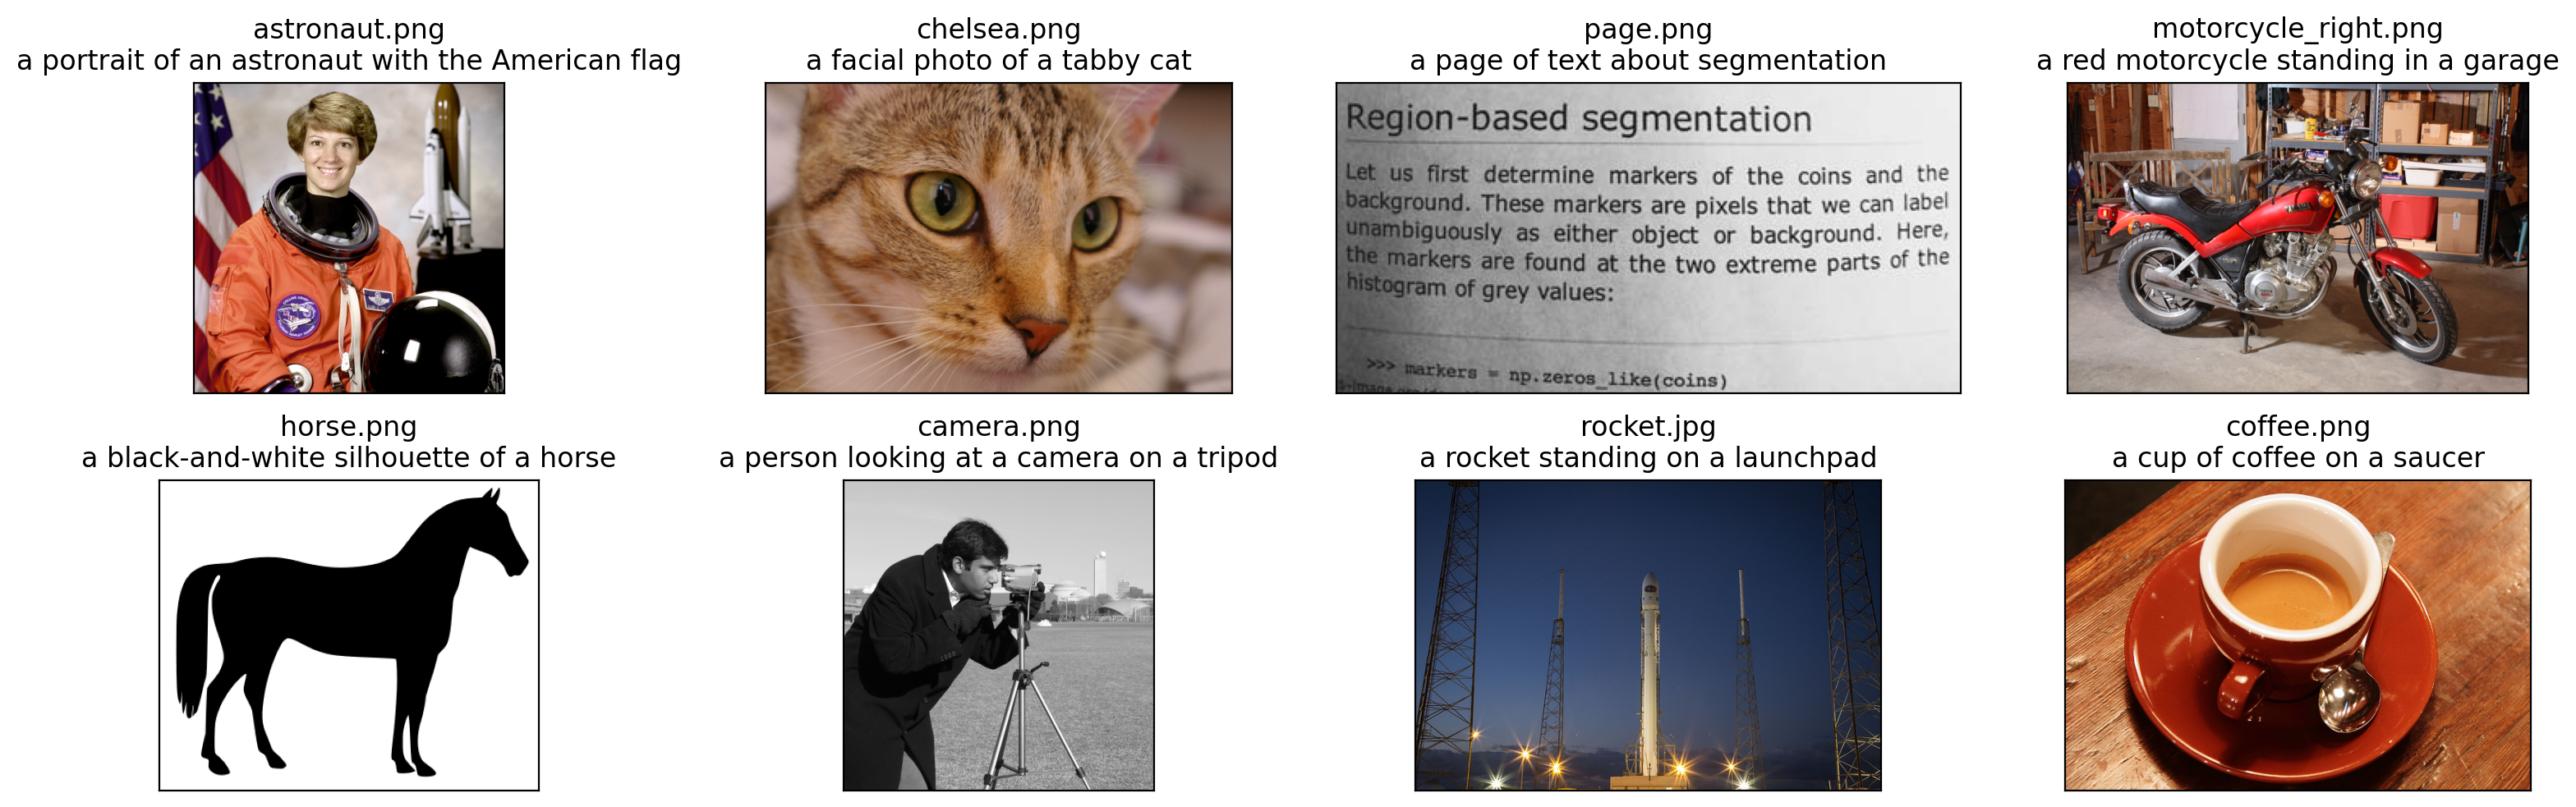

In [9]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])
plt.tight_layout()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [10]:
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [11]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

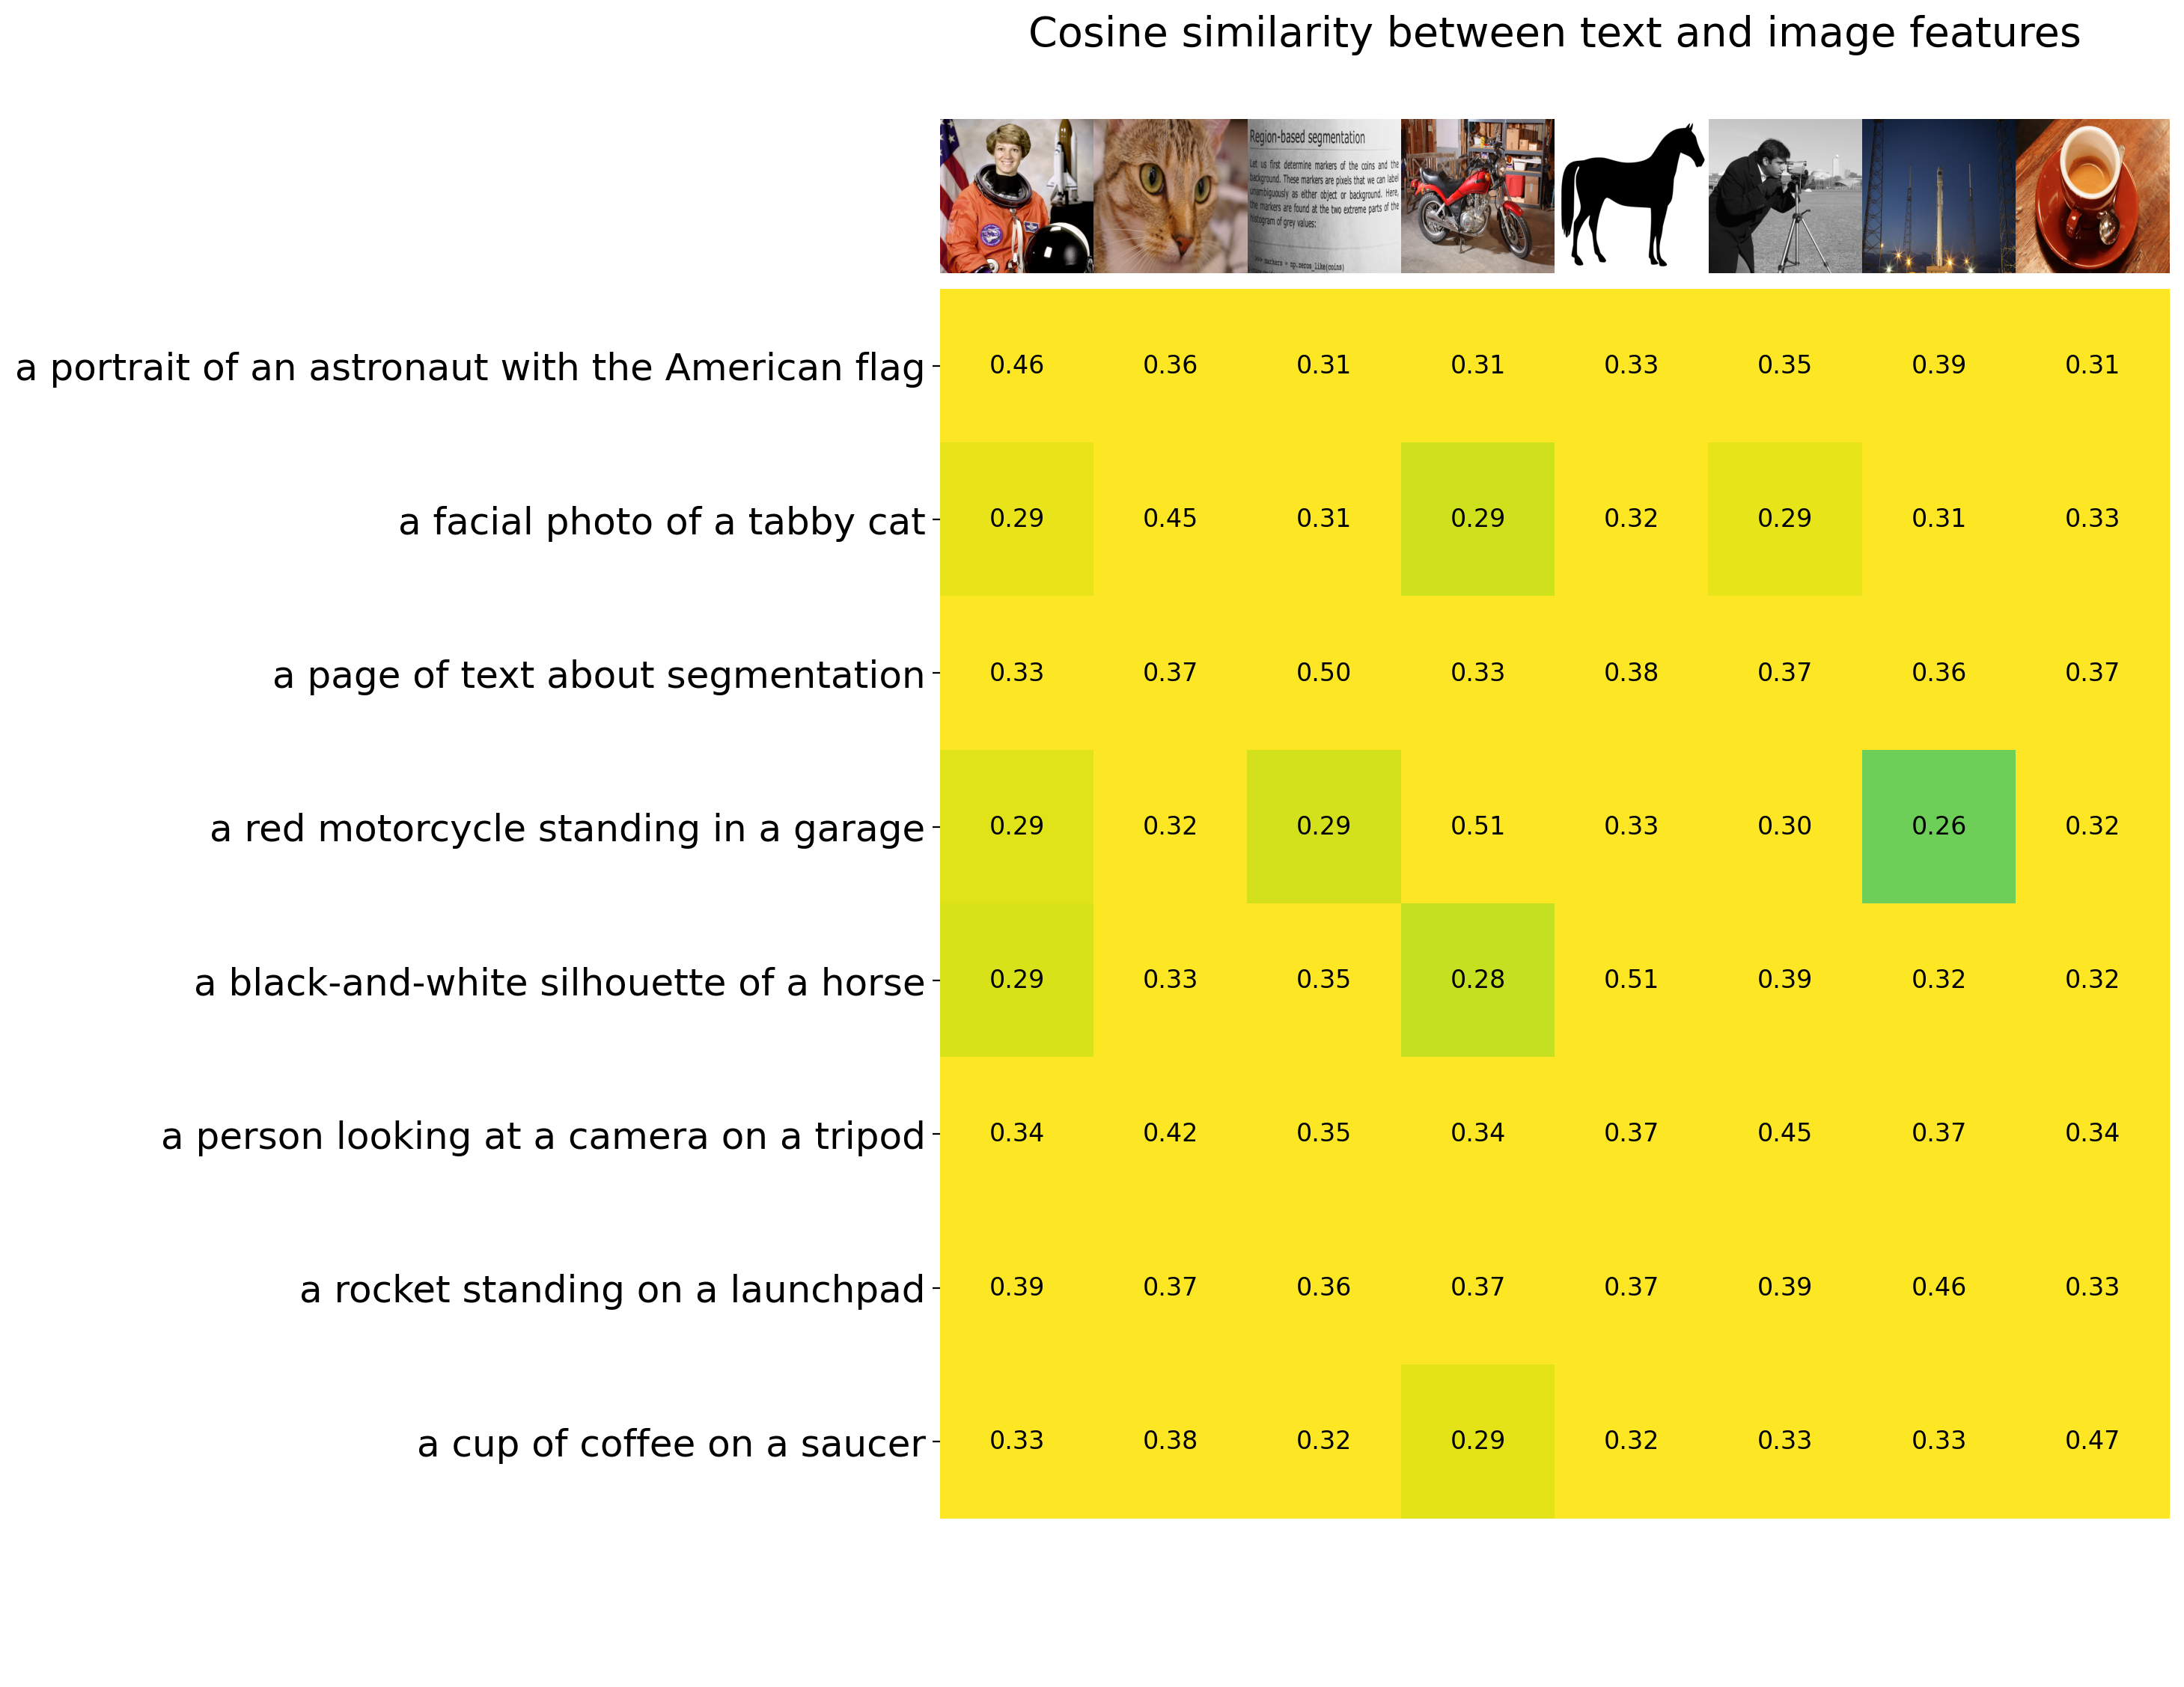

In [12]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

### Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [14]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

In [15]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

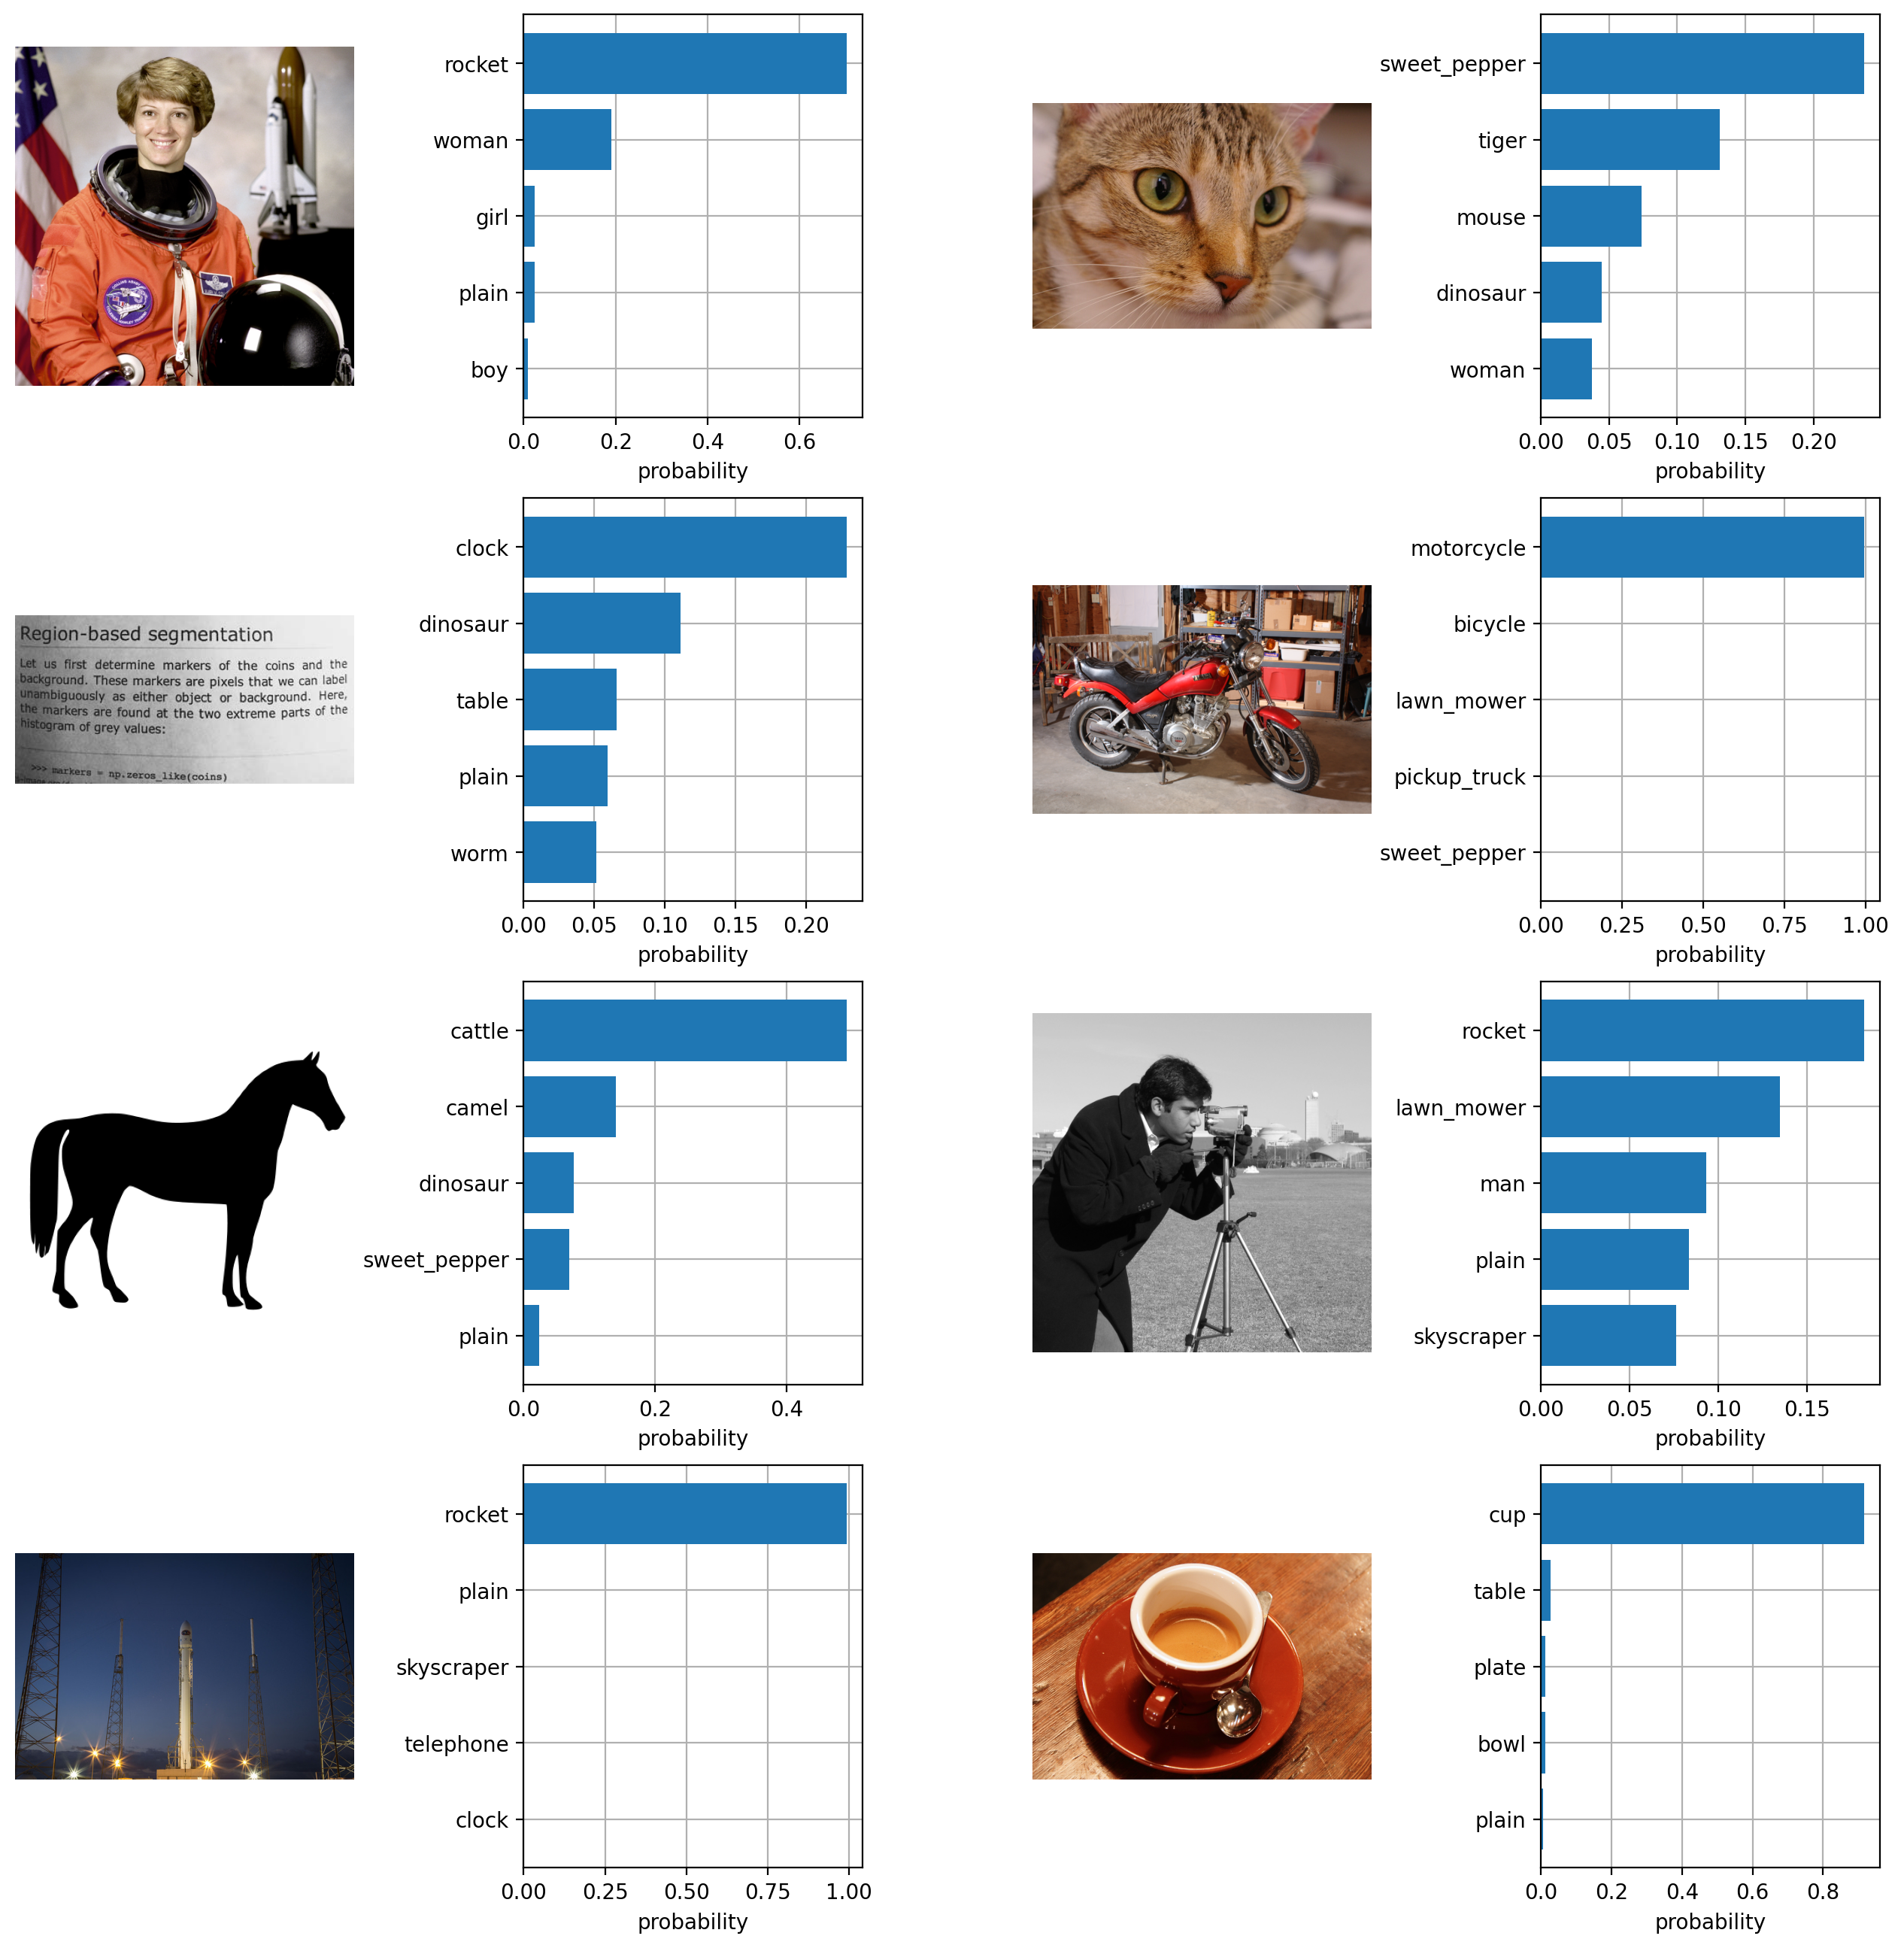

In [16]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# Let's start main work..

In [17]:
def get_image_features(images):
    imgs = []
    for image in images:
        imgs.append(preprocess(image))
    image_input = torch.tensor(np.stack(imgs)).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
    return image_features

In [18]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --") 
        # Broadcasting add. So just the last N dimensions need to match
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [19]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [20]:
class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta
        print(f"self.gamma: {self.gamma.size()}, self.beta: {self.beta.size()}")
        print(f"out: {out.size()}")
        return out

In [21]:
  
class FeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        print(f"x after 2nd linear layer: {x.size()}")
        return x

In [22]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = FeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual_x = x
        print("------- ATTENTION 1 ------")
        x = self.attention(x, mask=None)
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x

In [23]:
class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                     for _ in range(num_layers)])

    def forward(self, x):
        x = self.layers(x)
        return x

In [24]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 32
max_sequence_length = 1
ffn_hidden = 2048
num_layers = 5

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
     

# x = torch.randn( (batch_size, max_sequence_length, d_model) ) # includes positional encoding
# out = encoder(x)
     

In [25]:
folder_path = "images"

images = []

for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg')):
        image_path = os.path.join(folder_path, filename)
        img = Image.open(image_path)
        if img is not None:
            images.append(img)

In [26]:
x = get_image_features(images)

In [27]:
print(f"previous shape : {x.shape}")
x = x.unsqueeze(1)
print(f"Now shape is : {x.shape}")

previous shape : torch.Size([32, 512])
Now shape is : torch.Size([32, 1, 512])


In [28]:
output1 = encoder(x)

------- ATTENTION 1 ------
x.size(): torch.Size([32, 1, 512])
qkv.size(): torch.Size([32, 1, 1536])
qkv.size(): torch.Size([32, 1, 8, 192])
qkv.size(): torch.Size([32, 8, 1, 192])
q size: torch.Size([32, 8, 1, 64]), k size: torch.Size([32, 8, 1, 64]), v size: torch.Size([32, 8, 1, 64]), 
scaled.size() : torch.Size([32, 8, 1, 1])
values.size(): torch.Size([32, 8, 1, 64]), attention.size:torch.Size([32, 8, 1, 1]) 
values.size(): torch.Size([32, 1, 512])
out.size(): torch.Size([32, 1, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean (torch.Size([32, 1, 1]))
Standard Deviation  (torch.Size([32, 1, 1]))
y: torch.Size([32, 1, 512])
self.gamma: torch.Size([512]), self.beta: torch.Size([512])
out: torch.Size([32, 1, 512])
------- ATTENTION 2 ------
x after first linear layer: torch.Size([32, 1, 2048])
x after activation: torch.Size([32, 1, 2048])
x after dropout: torch.Size([32, 1, 2048])
x after 2nd linear layer: torch.Size([32, 1, 512])
------- DROPOUT 2 -----

In [29]:
learnable_quiries = torch.randn((batch_size,8, max_sequence_length, d_model//8))

learnable_quiries.shape

torch.Size([32, 8, 1, 64])

In [30]:
class MultiHeadAttention2(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        print(f"x.size(): {x.size()}")
        kv = self.kv_layer(x)
        print(f"kv.size(): {kv.size()}")
        kv = kv.reshape(batch_size, max_sequence_length, self.num_heads, 2 * self.head_dim)
        print(f"kv.size(): {kv.size()}")
        kv = kv.permute(0, 2, 1, 3)
        print(f"kv.size(): {kv.size()}")
        k, v = kv.chunk(2, dim=-1)
        q = learnable_quiries
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [31]:
class EncoderLayer2(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer2, self).__init__()
        self.attention = MultiHeadAttention2(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = FeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual_x = x
        print("------- ATTENTION 1 ------")
        x = self.attention(x, mask=None)
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x

In [32]:
class Encoder2(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer2(d_model, ffn_hidden, num_heads, drop_prob)
                                     for _ in range(num_layers)])

    def forward(self, x):
        x = self.layers(x)
        return x
     

In [33]:
encoder2 = Encoder2(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [34]:
output2 = encoder2(output1)
output2 = output2.squeeze()

------- ATTENTION 1 ------
x.size(): torch.Size([32, 1, 512])
kv.size(): torch.Size([32, 1, 1024])
kv.size(): torch.Size([32, 1, 8, 128])
kv.size(): torch.Size([32, 8, 1, 128])
q size: torch.Size([32, 8, 1, 64]), k size: torch.Size([32, 8, 1, 64]), v size: torch.Size([32, 8, 1, 64]), 
scaled.size() : torch.Size([32, 8, 1, 1])
values.size(): torch.Size([32, 8, 1, 64]), attention.size:torch.Size([32, 8, 1, 1]) 
values.size(): torch.Size([32, 1, 512])
out.size(): torch.Size([32, 1, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean (torch.Size([32, 1, 1]))
Standard Deviation  (torch.Size([32, 1, 1]))
y: torch.Size([32, 1, 512])
self.gamma: torch.Size([512]), self.beta: torch.Size([512])
out: torch.Size([32, 1, 512])
------- ATTENTION 2 ------
x after first linear layer: torch.Size([32, 1, 2048])
x after activation: torch.Size([32, 1, 2048])
x after dropout: torch.Size([32, 1, 2048])
x after 2nd linear layer: torch.Size([32, 1, 512])
------- DROPOUT 2 ------
-

In [35]:
output2.shape

torch.Size([32, 512])

In [36]:
class Final_layer(nn.Module):
    def __init__(self):
        super(Final_layer, self).__init__()
        self.fc = nn.Linear(512, 512)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [37]:
model = Final_layer()

In [38]:
output3 = model(output2)

In [39]:
output3.shape

torch.Size([32, 512])

In [40]:
import torch

def asymmetric_loss(predictions, targets, beta=0.2):
    """
    Compute asymmetric loss for multi-label classification.
    
    Arguments:
    - predictions (torch.Tensor): Predicted probabilities (batch_size, num_classes).
    - targets (torch.Tensor): Ground truth labels (batch_size, num_classes).
    - beta (float): Weighting factor for positive samples. Default is 0.2.
    
    Returns:
    - loss (torch.Tensor): Asymmetric loss.
    """
    # Compute positive loss
    positive_loss = -torch.mean(beta * targets * torch.log(predictions + 1e-15))
    
    # Compute negative loss
    negative_loss = -torch.mean((1 - beta) * (1 - targets) * torch.log(1 - predictions + 1e-15))
    
    # Total loss
    loss = positive_loss + negative_loss
    
    return loss

In [41]:
concept_vocabulary = ["playing", "book", "table", "chair", "phone", "computer", "house", "car", "tree", "flower", "sun", "cloud", "sky", "grass", "mountain", "road", "street", "path", "bridge", "building", "tower", "door", "window", "mirror", "picture", "frame", "light", "lamp", "shadow", "reflection", "water", "lake", "ocean", "wave", "boat", "ship", "fish", "bird", "plane", "balloon", "kite", "flag", "banner", "sign", "poster", "advertisement", "banner", "hoarding", "billboard", "painting", "drawing", "sketch", "sculpture", "statue", "figure", "model", "mannequin", "dummy", "prop", "accessory", "ornament", "decoration", "curtain", "blind", "rug", "carpet", "mat", "cushion", "pillow", "blanket", "sheet", "towel", "cloth", "fabric", "textile", "sewing", "needle", "thread", "yarn", "fiber", "pattern", "design", "print", "texture", "embroidery", "stitch", "applique", "patchwork", "quilting", "weaving", "knitting", "crochet", "macrame", "basket", "bag", "purse", "wallet", "pocket", "compartment", "container", "box", "case", "crate", "barrel", "jar", "bottle", "can", "tin", "drum", "cylinder", "tube", "cone", "pyramid", "prism", "sphere", "globe", "orb", "oval", "egg", "marble", "stone", "rock", "pebble", "crystal", "gem", "jewel", "treasure", "gold", "silver", "bronze", "brass", "iron", "steel", "metal", "liquid", "gas", "plasma", "vapor", "mist", "fog", "cloud", "smoke", "fume", "vapor", "steam", "rain", "drizzle", "hail", "sleet", "snow", "frost", "ice", "glacier", "iceberg", "icicle", "floe", "drift", "firn", "permafrost", "tundra", "steppe", "plain", "plateau", "mesa", "butte", "volcano", "caldera", "crater", "cone", "lava", "magma", "igneous", "sedimentary", "metamorphic", "rocky", "mountainous", "hilly", "rolling", "undulating", "flat", "level", "graded", "sloping", "steep", "sheer", "cliff", "gorge", "canyon", "ravine", "valley", "glen", "dell", "hollow", "den", "lair", "cave", "cavern", "grotto", "catacomb", "crypt", "mausoleum", "pyramid", "tomb", "grave", "cemetery", "graveyard", "burial", "ground", "earth", "dirt", "soil", "loam", "clay", "mud", "sand", "grit", "gravel", "pebble", "boulder", "cobble", "stone", "rock", "rubble", "debris", "slag", "ash", "dust", "powder", "granules", "crumbs", "flakes", "chips", "shards", "splinters", "fragments", "pieces", "parts", "ingredients", "components", "constituents", "elements", "atoms", "molecules", "compounds", "mixtures", "solutions", "suspensions", "emulsions", "colloids", "gels", "foams", "solids", "liquids", "gases", "plasmas", "vapors", "mists", "fogs", "clouds", "smokes", "fumes", "vapors", "steams", "condensates", "dews", "rains", "drizzles", "hails", "sleets", "snows", "frosts", "ices", "glaciers", "icebergs", "icicles", "floes", "drifts", "firns", "permafrosts", "tundras", "steppes", "plains", "plateaus", "mesas", "buttes", "volcanos", "calderas", "craters", "cones", "lavas", "magmas", "igneouses", "sedimentaries", "metamorphics", "rockies", "mountainouses", "hillies", "rollings", "undulatings", "flats", "levels", "gradeds", "slopings", "steeps", "sheers", "cliffs", "gorges", "canyons", "ravines", "valleys", "glens", "dells", "hollows", "dens", "lairs", "caves", "caverns", "grottos", "catacombs", "crypts", "mausoleums", "pyramids", "tombs", "graves", "cemeteries", "graveyards", "burials", "grounds", "earths", "dirts", "soils", "loams", "clays", "muds", "sands", "grits", "gravels", "pebbles", "boulders", "cobbles", "stones", "rocks", "rubbles", "debrises", "slags", "ashes", "dusts", "powders", "granule", "crumb", "flake", "chip", "shard", "splinter", "fragment", "piece", "part", "ingredient", "component", "constituent", "element", "atom", "molecule", "compound", "mixture", "solution", "suspension", "emulsion", "colloid", "gel", "foam", "solid", "liquid", "gas", "plasma", "vapor", "mist", "fog", "cloud", "smoke", "fume", "vapor", "steam", "condensate", "dew", "rain", "drizzle", "hail", "sleet", "snow", "frost", "ice", "glacier", "iceberg", "icicle", "floe", "drift", "firn", "permafrost", "tundra", "steppe", "plain", "plateau", "mesa", "butte", "volcano", "caldera", "crater", "cone", "lava", "magma", "igneous", "sedimentary", "metamorphic", "rocky", "mountainous", "hilly", "rolling", "undulating", "flat", "level", "graded", "sloping", "steep", "sheer", "cliff", "gorge", "canyon", "ravine", "valley", "glen", "dell", "hollow", "den", "lair", "cave", "cavern", "grotto", "catacomb", "crypt", "mausoleum", "pyramid", "tomb", "grave", "cemetery", "graveyard", "burial", "ground", "earth", "dirt", "soil", "loam", "clay", "mud", "sand", "grit", "gravel", "pebble", "boulder", "cobble", "stone", "rock", "rubble", "debris", "slag", "ash", "dust", "powder", "granules", "crumbs", "flakes", "chips", "shards", "splinters", "fragments", "pieces", "parts", "ingredients", "components", "constituents", "elements", "atoms", "molecules", "compounds", "mixtures", "solutions", "suspensions", "emulsions", "colloids", "gels", "foams", "solids", "liquids", "gases", "plasmas", "vapors", "mists", "fogs", "clouds", "smokes", "fumes", "vapors", "steams", "condensates", "dews", "rains", "drizzles", "hails", "sleets", "snows", "frosts", "ices"]
len(concept_vocabulary)

512

In [42]:
def tokenize_sentence(sentence):
    # Tokenize the sentence into individual words or tokens
    return sentence.lower().split()

def encode_sentence(sentence):
    words_array = tokenize_sentence(sentence)
    binary_array = [0] * 512
    for word in words_array:
        if word in concept_vocabulary:
            index = concept_vocabulary.index(word)
            binary_array[index] = 1
    return binary_array

In [43]:
sentences = [
    "The children are playing in the park",
    "She reads a new book every week",
    "They gathered around the table for a meeting",
    "He sat on the comfortable chair by the fireplace",
    "I forgot my phone charger at home",
    "He works on his computer late into the night",
    "Their new house has a beautiful garden",
    "She drove her car to work",
    "The tree branches sway in the wind",
    "The flower garden is in full bloom",
    "The sun sets behind the mountains",
    "The sky is painted with shades of pink and orange",
    "The cloud looks like a fluffy cotton ball",
    "The kids enjoy playing soccer in the backyard",
    "She's lost in her book and doesn't notice the time",
    "The table is set for dinner",
    "He reclined on the plush chair and closed his eyes",
    "My phone battery is running low",
    "Their house has a cozy fireplace",
    "The car engine roared to life",
    "The tall tree provides shade on hot days",
    "She carefully arranged the flowers in a vase",
    "The sunflowers face towards the sun",
    "The sky is clear and blue",
    "The clouds are fluffy and white",
    "They are playing basketball at the park",
    "He's reading a book about ancient history",
    "The table is made of solid wood",
    "She sat on the rocking chair on the porch",
    "I need to buy a new phone case",
    "She works as a computer engineer at a tech company",
    "Their house has a beautiful view of the mountains",
]

In [44]:
encoded_sentences = []

# Encode each sentence in the sentences array
for sentence in sentences:
    encoded_sentence = encode_sentence(sentence)
    encoded_sentences.append(encoded_sentence)

# Stack the encoded sentences using np.stack
stacked_encoded_sentences = np.stack(encoded_sentences)

# Convert the stacked array to a PyTorch tensor
encoded_sentences = torch.tensor(stacked_encoded_sentences, dtype=torch.float32)

loss = asymmetric_loss(output3, encoded_sentences)
print("Asymmetric Loss:", loss.item())

Asymmetric Loss: 0.5773301720619202
